# PhotoRing Utilities
## Computing the probability distribution of ring parameters from observed stellar density
### By Jorge I. Zuluaga & David Kipping

Libraries required

In [16]:
import photoring as pr
import photoring.constants as c
import pickle
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.interpolate import interp1d
from scipy.stats import norm
from copy import deepcopy
import time
import os

# Check if this is a notebook or a stand alone script
try:
    get_ipython
except:
    get_ipython = pr.get_ipython

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## True stellar density

The first step is to get the true stellar desnsity as given by some work. Here we use Berger et al. 

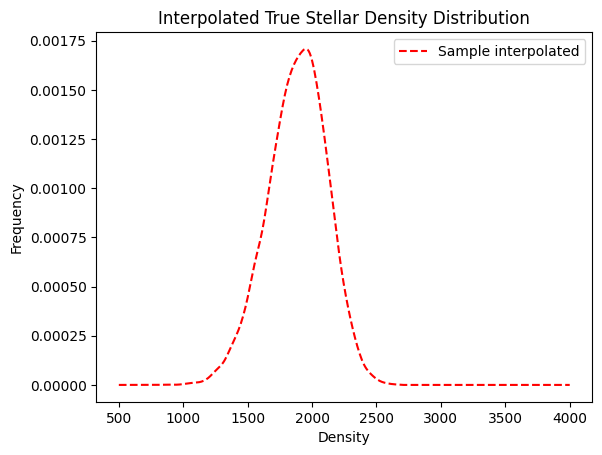

In [17]:
# Unpickle the functions
with open(pr.DATA_DIR + 'kepler51/rho_true_fun.pkl', 'rb') as f:
    rho_true_fun = pickle.load(f)

# Interpolated/Extrapolated values
x = np.linspace(500, 4000, 400)
y = rho_true_fun(x)
plt.plot(x, y, 'r--',label='Sample interpolated')

# Decoration
plt.legend()
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.title('Interpolated True Stellar Density Distribution')
plt.savefig(f"{pr.PRFIG_DIR}/rho_true_kepler51.png");
plt.show()

We need also the observed mass and stellar radius that can be obtained from the KIC catalogue:

In [18]:
df = pd.read_csv(pr.DATA_DIR + 'GKTHCatalogue.csv')
k51 = df[df['id_starname'] == 'kic11773022']

rho_true_sun = c.MSUN/(4/3 * np.pi * c.RSUN**3)

M_mean = k51.iso_mass.values[0]
R_mean = k51.iso_rad.values[0]
M_std = (k51.iso_mass_err1.values[0] + abs(k51.iso_mass_err2.values[0]))/2
R_std = (k51.iso_rad_err1.values[0] + abs(k51.iso_rad_err2.values[0]))/2

Ms_mean = M_mean*c.MSUN
Ms_std = M_std*c.MSUN
Rs_mean = R_mean*c.RSUN
Rs_std = R_std*c.RSUN

print(f"Mass: {M_mean} +/- {M_std}")
print(f"Radius: {R_mean} +/- {R_std}")

Mass: 0.9146640833784588 +/- 0.04980093747925855
Radius: 0.8688315952605846 +/- 0.02891379267492005


In order to reconstruct the stellar densities we will assume for simplicity that stellar mass and radius are distributed according to a multivariate normal distribution with a conjectured correlation:

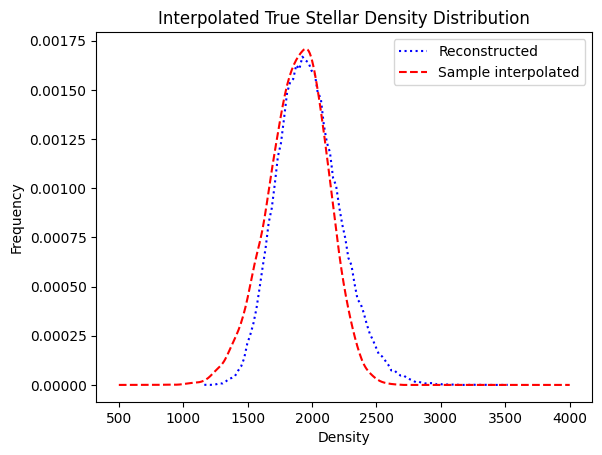

In [19]:
mean = [M_mean, R_mean]
rho_MR = -0.2
cov = [
    [M_std**2, rho_MR * M_std * R_std], 
    [rho_MR * M_std * R_std, R_std**2]
]

samples = np.random.multivariate_normal(mean, cov, int(1e5))
mass_samples = samples[:, 0]
radius_samples = samples[:, 1]
rho_samples = mass_samples / (radius_samples**3)*rho_true_sun

# Histogram rho_samples
bins = int(len(rho_samples)/1000)
hs,rhos = np.histogram(rho_samples, bins=bins, density=True)
rhos = 0.5*(rhos[1:] + rhos[:-1])
rho_sample_fun = interp1d(rhos, hs, kind='cubic', fill_value=(0,0), bounds_error=False)
plt.plot(rhos, hs, 'b:',label='Reconstructed')

# Interpolated/Extrapolated values
x = np.linspace(500, 4000, 400)
y = rho_true_fun(x)
plt.plot(x, y, 'r--',label='Sample interpolated')

# Decoration
plt.legend()
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.title('Interpolated True Stellar Density Distribution')
plt.savefig(f"{pr.PRFIG_DIR}/rho_true_reconstruction_kepler51.png");
plt.show()

Using the distribution we can create a distribution of masses and radius in a mesh for using in the reconstruction of ring properties:

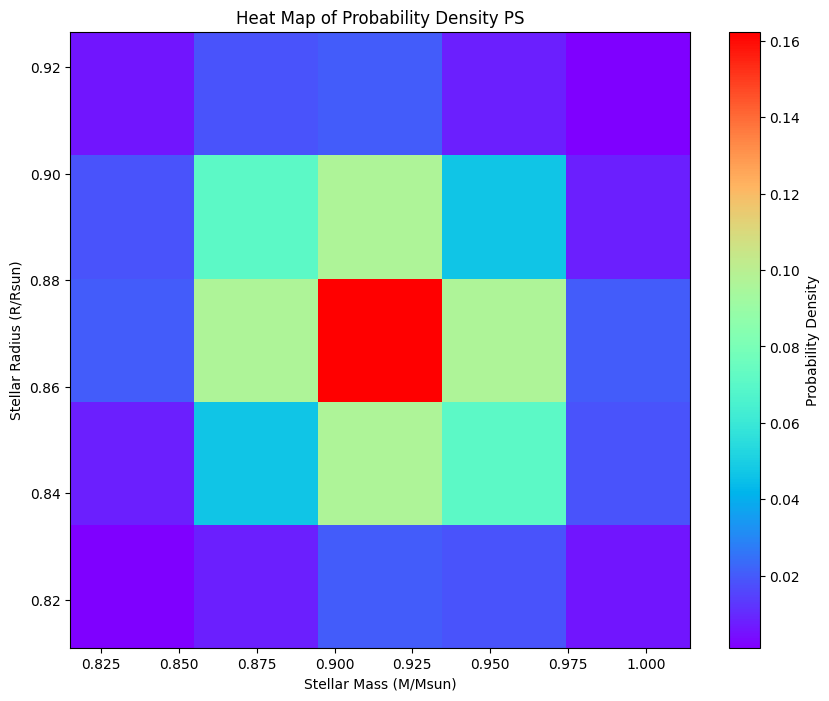

Minimum: 0.0010944907754310371, Maximum: 0.16243683359034986


In [20]:
Ns = int(1e4)
Ng = 5
ts = 2
MS, RS = np.meshgrid(
    np.linspace(Ms_mean - ts*Ms_std, Ms_mean + ts*Ms_std, Ng)/c.MSUN,
    np.linspace(Rs_mean - ts*Rs_std, Rs_mean + ts*Rs_std, Ng)/c.RSUN
)
delta_Ms = MS[0,1] - MS[0,0]
delta_Rs = RS[1,0] - RS[0,0]

PS = np.zeros(MS.shape)
for i in range(MS.shape[0]):
    for j in range(RS.shape[1]):
        PS[i, j] = multivariate_normal.pdf([MS[i, j], RS[i, j]], mean=mean, cov=cov)
PS = PS*delta_Ms*delta_Rs

# Heat map
plt.figure(figsize=(10, 8))
plt.imshow(PS, extent=[MS.min(), MS.max(), RS.min(), RS.max()], 
           origin='lower', aspect='auto', cmap='rainbow')
plt.colorbar(label='Probability Density')
plt.xlabel('Stellar Mass (M/Msun)')
plt.ylabel('Stellar Radius (R/Rsun)')
plt.title('Heat Map of Probability Density PS')
plt.savefig(f"{pr.PRFIG_DIR}/MR_meshgrid_kepler51.png");
plt.show()

print(f"Minimum: {PS.min()}, Maximum: {PS.max()}")

## Observed stellar density

In a previous step we have created interpolation functions for the true and observed stellar density. These interpolations have been pickled. Here we unpickled them to use in the following calculations:

In [21]:
with open(pr.DATA_DIR + 'kepler51/rho_obs_b_fun.pkl', 'rb') as f:
    rho_obs_b_fun = pickle.load(f)

Plot observed densities as compared with true density:

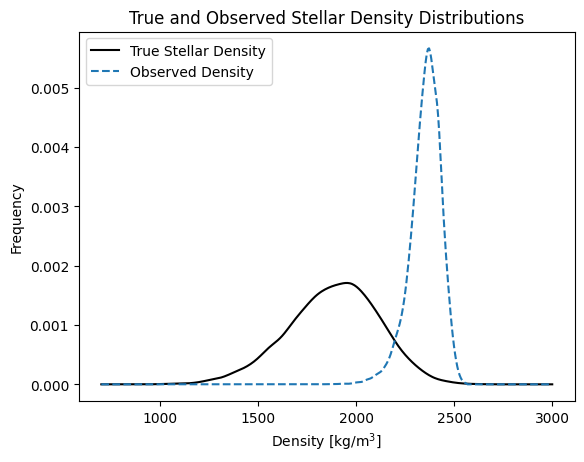

In [22]:
# Define the range for x-axis
x_range = np.linspace(700, 3000, 400)

# Plot rho_true_fun
plt.plot(x_range, rho_true_fun(x_range), label='True Stellar Density', color='black')

# Plot rho_obs_*_fun for each planet
plt.plot(x_range, rho_obs_b_fun(x_range), label='Observed Density', linestyle='--')

# Decoration
plt.xlabel(r'Density [kg/m$^3$]')
plt.ylabel('Frequency')
plt.title('True and Observed Stellar Density Distributions')
plt.legend()
plt.savefig(f"{pr.PRFIG_DIR}/rho_obs_b_kepler51.png");
plt.show()

## Planetary information

Now we need to load the planet information:

In [23]:
# https://exoplanetarchive.ipac.caltech.edu/overview/Kepler-51
# Planet b: Masuda et al. 2024
system_prefix = 'k51-planet_b'
rho_obs_fun = rho_obs_b_fun

# Planetary radius
Rp_mean = 0.609*c.RJUP # Masuda et al. 2024
Rp_std = 0.012*c.RJUP # Masuda et al. 2024

# Orbital period
Porb_mean = 45.15405*c.DAY # Masuda et al. 2024
Porb_std = 0.00039*c.DAY # Masuda et al. 2024

# Impact parameter
borb_mean = 0.0740 # Masuda et al. 2024
borb_std = 0.0720 # Masuda et al. 2024

# Planetary mass
Mp_mean = 0.011*c.MJUP
Mp_std = 0.007*c.MJUP

With this information we create the datasheet for geotrans:

In [24]:
# ============================
# TRANSIT DEPTH
# ============================
delta_mean = (Rp_mean/Rs_mean)**2
delta_std = 2*delta_mean*(Rp_std/Rp_mean + Rs_std/Rs_mean)
print(f"Transit depth: {delta_mean*100:.2f} +/- {delta_std*100:.2f} %")

# ============================
# SEMIMAJOR AXIS
# ============================
# Semimajor axis
ap_mean = ((c.GCONST * Ms_mean * Porb_mean**2) / (4 * np.pi**2))**(1/3)
ap_std = 1/3*ap_mean*(Ms_std/Ms_mean + 2*Porb_std/Porb_mean)
print(f"Semimajor axis: {ap_mean/c.AU:.4f} +/- {ap_std/c.AU:.4f} au = {ap_mean/Rs_mean:.2f} Rs")

# ============================
# ORBITAL INCLINATION
# ============================
iorb_mean = np.arccos(borb_mean*Rs_mean/ap_mean)*c.RAD
iorb_std = np.sqrt((borb_std * Rs_mean / ap_mean)**2 + \
                   (borb_mean * Rs_std / ap_mean)**2 + \
                   (borb_mean * Rs_mean * ap_std / ap_mean**2)**2) * c.RAD
print(f"Orbital inclination: {iorb_mean:.2f} +/- {iorb_std:.2f} degrees")

# ============================
# MINIMUM PLANET RADIUS
# ============================
Rp_min = c.REARTH*(Mp_mean/c.MEARTH)**(1/3)
fRp_min = Rp_min/Rp_mean
print(f"Minimum planet radius: {Rp_min/c.RJUP:.4f} RJup")
print(f"Minimum planet radius in terms of the ringless planet radius: {fRp_min:.4f} Rp")

System = pr.RingedSystem(
    system = dict(
        Mstar=Ms_mean,
        Rstar=Rs_mean,
        Rplanet=Rp_mean, 
        Mplanet=Mp_mean, 
        ap=ap_mean, #Semi-major axis 
        iorb=iorb_mean*c.DEG, #Orbital inclination
        fe=1, #Exterior ring (Rp)
        fi=1, #Interior ring (Rp)
        ir=0.0*c.DEG, #Ring inclination
        phir=0.0*c.DEG, #Ring roll angle
        tau=1.0, #Opacity
    )
)
System.noauto = True

# Useful additional parameters
System.Porb_mean = Porb_mean
System.borb_mean = borb_mean
System.delta_mean = delta_mean
System.delta_std = delta_std
System.delta_fun = lambda x:norm.pdf(x, delta_mean, delta_std)
System.rho_obs_fun = rho_obs_fun
System.rho_true_fun = rho_true_fun

# Adjust
print()
print("After adjustment:")
pr.standard_adjust_params(System,True)

System.calculate_PR()
print(f"rho_obs: {System.rho_obs}, rho_true: {System.rho_true}, PR: {System.PR}")

Transit depth: 0.50 +/- 0.05 %
Semimajor axis: 0.2409 +/- 0.0044 au = 59.57 Rs
Orbital inclination: 89.93 +/- 0.07 degrees
Minimum planet radius: 0.1383 RJup
Minimum planet radius in terms of the ringless planet radius: 0.2271 Rp

After adjustment:
Semimajor axis: 0.2409 au = 59.57 Rs
Orbital inclination: 89.93 degrees
rho_obs: 1960.2730428867958, rho_true: 1960.8074257658545, PR: -0.0001183752993038757


## Parameter space

We will explore the parameter space that are compatible with the observed density and transit depth. For this purpose I will describe the space dimensions:

In [25]:
# Parameter space
props = dict(
    fe = dict(
        label=r"$f_e$",
        range=[1.1,6.0],
        scale=1,
    ),
    Rplanet = dict(
        label=r"$R_p$ [$R_{jup}$]",
        range=[fRp_min*Rp_mean/c.RJUP, Rp_mean/c.RJUP],
        scale=c.RJUP,
    ),
    ir = dict(
        label=r"$i_r$ [deg]",
        range=[0.0, 90.0],
        scale=c.DEG,
    ),
    phir = dict(
        label=r"$\phi_r$ [deg]",
        range=[0.0, 90.0],
        scale=c.DEG,
    ),
)

During the search we want that the resulting samples store information. Here we describe which information will be stored:

In [26]:
# Parameters to store
store_params = dict(
    # Basic
    rho_true = dict(prop='rho_true',scale=1),
    rho_obs = dict(prop='rho_obs',scale=1),
    PR = dict(prop='PR',scale=1),
    ieff = dict(prop='ieff',scale=c.RAD),
    teff = dict(prop='teff',scale=c.RAD),
    delta = dict(prop='Ar',scale=1/np.pi),
    
    # Other
    Rstar = dict(prop='Rstar',scale=1/c.RSUN),
    Mstar = dict(prop='Mstar',scale=1/c.MSUN),
    ap = dict(prop='ap',scale=1/c.AU),
    ep = dict(prop='ep',scale=1),
    iorb = dict(prop='iorb',scale=c.RAD),
    Borb = dict(prop='Borb',scale=1),
    Porb = dict(prop='Porb',scale=1/c.DAY),
    tT = dict(prop='tT',scale=1),
    grazing = dict(prop='grazing',scale=1),
)

It is important to say that all these properties are in the object System:

In [27]:
System.__dict__.keys()

dict_keys(['noauto', 'Ddet', 'qeff', 'Mstar', 'Rstar', 'Lstar', 'Tstar', 'Dstar', 'c1', 'c2', 'ap', 'ep', 'iorb', 'wp', 'Mplanet', 'Rplanet', 'fp', 'fe', 'fi', 'ir', 'phir', 'tau', 'Mi', 'Mw', 'Mos', 'Rp', 'Ri', 'Re', 'Flux', 'rho_true', 'Porb', 'norb', 'fcen', 'Ecen', 'Mcen', 'tcen', 'rcen', 'Pcen', 'Borb', 'orbit', 'C', 'Star', 'Planet', 'Mrs', 'ieff', 'teff', 'block', 'dtrans', 'dtplanet', 'dtstar', 'Ringext', 'Ringint', 'Ar', 'Ap', 't', 'Mt', 'Et', 'rp', 'rs', 'grazing', 'Porb_mean', 'borb_mean', 'delta_mean', 'delta_std', 'delta_fun', 'rho_obs_fun', 'rho_true_fun', 'tT', 'tF', 'rho_obs', 'PR'])

Now we're ready to generate a sample first, sequentially:

In [28]:
S = deepcopy(System)
S.tau = 1
S.fi = 1

samples = 10
Xs = pr.mcra_grid_general(S, props, store_params, samples, verbose=True)
Xs

Maximum probabilities: p_delta_max: 760.2059415754229, p_rho_obs_max: 0.005667111080694299
Testing point: 0 (0 accepted)
Guess parameters: fe: 2.4442272663692006, Rplanet: 0.5739267169266542, ir: 73.3054971620085, phir: 68.70308731391209
	rho_obs: 2856.404820859727, rho_true: 1960.8074257658545, PR: 0.16338481441615052, delta: 0.00917045459974202 (target 0.004952325951451528)
	Probabilities: p_rho_obs: 0.0, p_delta: 7.105917670130562e-12
	Acceptance ratio: 0.0
	Random number: 0.9667104272292852
		Rejected
Testing point: 1 (0 accepted)
Guess parameters: fe: 4.9574454352931845, Rplanet: 0.42611334004784895, ir: 66.5848936073062, phir: 32.17886529428098
	rho_obs: 1584.73499085769, rho_true: 1960.8074257658545, PR: -0.0924782957336761, delta: 0.034166027526034155 (target 0.004952325951451528)
	Probabilities: p_rho_obs: 0.0, p_delta: 0.0
	Acceptance ratio: 0.0
	Random number: 0.4178838430432512
		Rejected
Testing point: 2 (0 accepted)
Guess parameters: fe: 1.2868813000356307, Rplanet: 0.468

,fe,Rplanet,ir,phir,rho_true,rho_obs,PR,ieff,teff,delta,Rstar,Mstar,ap,ep,iorb,Borb,Porb,tT,grazing
0,1.642666,0.476342,75.018300,50.717710,1960.807426,2349.127576,0.078472,52.316543,70.876256,0.004614,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.123077,0
1,2.111314,0.388411,76.741096,53.483511,1960.807426,2413.089754,0.090139,54.626315,73.610872,0.004632,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.117345,0
2,2.073638,0.568159,73.811960,82.654157,1960.807426,2273.519706,0.064264,82.966917,73.676655,0.005252,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.156707,0
3,1.983340,0.519796,75.505733,82.663627,1960.807426,2232.621242,0.056380,82.916306,75.382625,0.004291,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.124260,0
4,1.764305,0.519148,69.048563,73.936799,1960.807426,2335.051511,0.075862,75.051014,68.257596,0.004544,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.123825,0
5,1.299645,0.601282,87.736452,42.184132,1960.807426,2241.033041,0.058013,42.237672,86.553062,0.005771,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.178930,0
6,1.536813,0.523458,65.109673,54.186425,1960.807426,2237.494434,0.057327,57.975966,60.184855,0.004789,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.140070,0
7,4.546486,0.196942,74.615142,55.723211,1960.807426,2332.907775,0.075463,57.133757,71.538917,0.004971,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.136299,0
8,2.222333,0.477557,64.393419,61.546959,1960.807426,2103.937667,0.030598,64.589119,61.375252,0.006159,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.197452,0
9,2.144866,0.407536,89.643643,48.889153,1960.807426,2371.162617,0.082526,48.890746,89.464918,0.005727,0.868832,0.914664,0.240896,0.0,89.92882,-0.074,45.153791,6.162258,0


Now we can run it in parallel:

In [32]:
S = deepcopy(System)
S.tau = 1
S.fi = 1

# Total number of processors
num_procs = 4

# Total size of the sample
samples = int(1e2)

# Name of the sample
sample_suffix = f"MR_simple_variance-N{samples:.0e}"

# Prepare the data
Xs = pd.DataFrame([],columns=list(props.keys()) + ['rho_true', 'rho_obs', 'PR', 'ieff', 'teff', 'delta'])

# Loop over the grid
Nsamples = 0
n = 0 
glob_start_time = time.time()
for i in range(MS.shape[0]):
    for j in range(RS.shape[1]):
        n += 1 

        # Update stellar parameters
        S.Mstar = MS[i, j]*c.MSUN
        S.Rstar = RS[i, j]*c.RSUN
        S.updateSystem()
        
        # Calculate the number of samples required
        sub_samples = int(PS[i,j]*samples)
        
        print(f"Stellar parameters {n}: M_star = {S.Mstar/c.MSUN}, R_star = {S.Rstar/c.RSUN}, Number of samples: {sub_samples}")

        start_time = time.time()
        results = pr.parallel_mcra_grid(S, props, store_params, sub_samples, num_procs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"\tExecution time: {execution_time:.2f} seconds")

        Nsamples += len(results)

        # Accumulate
        if Nsamples > 0:
            Xs = pd.concat([Xs,results], ignore_index=True)
        
        # Save accumulated
        Xs.to_csv(f"{pr.PRDATA_DIR}/ringed_sample-{system_prefix}-{sample_suffix}.csv", index=False)
    
glob_end_time = time.time()
elapsed_time = glob_end_time - glob_start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours):02}:{int(minutes):02}:{seconds:.2f} (hh:mm:ss)")
os.system('say "Tu programa ha terminado"')

Stellar parameters 1: M_star = 0.8150622084199416, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.06 seconds
Stellar parameters 2: M_star = 0.8648631458992002, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.05 seconds
Stellar parameters 3: M_star = 0.9146640833784587, R_star = 0.8110040099107445, Number of samples: 2
	Execution time: 0.03 seconds
Stellar parameters 4: M_star = 0.9644650208577173, R_star = 0.8110040099107445, Number of samples: 1
	Execution time: 0.03 seconds
Stellar parameters 5: M_star = 1.014265958336976, R_star = 0.8110040099107445, Number of samples: 0
	Execution time: 0.02 seconds
Stellar parameters 6: M_star = 0.8150622084199416, R_star = 0.8399178025856646, Number of samples: 0
	Execution time: 0.02 seconds
Stellar parameters 7: M_star = 0.8648631458992002, R_star = 0.8399178025856646, Number of samples: 4
	Execution time: 1.68 seconds
Stellar parameters 8: M_star = 0.9146640833784587, R_star = 0.8399178025856646, Numb

0

Now that we have the samples we can plot the distribution:

(<photoring.plot.PlotGrid at 0x112a8f950>,
 <Figure size 1200x600 with 3 Axes>,
 <Figure size 1800x600 with 4 Axes>)

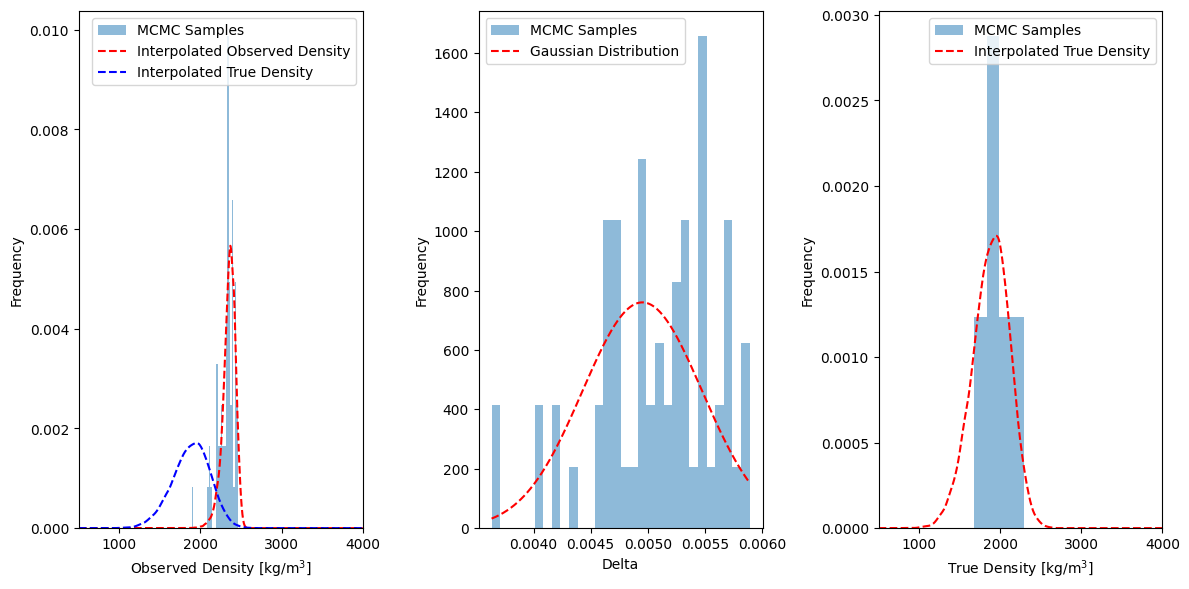

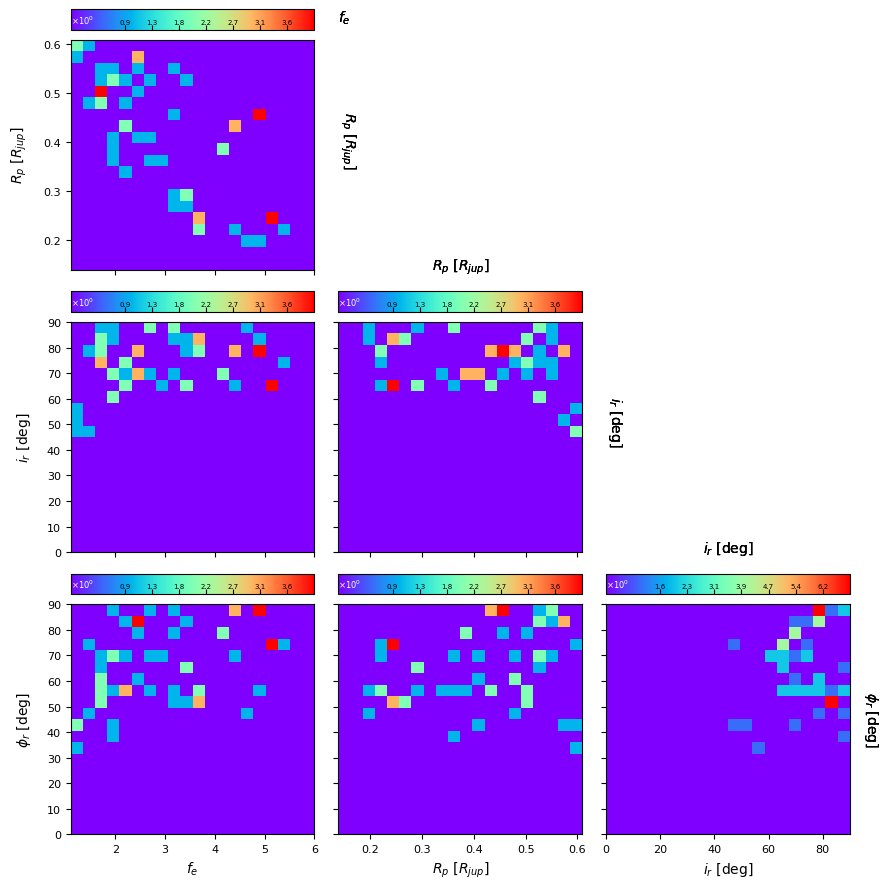

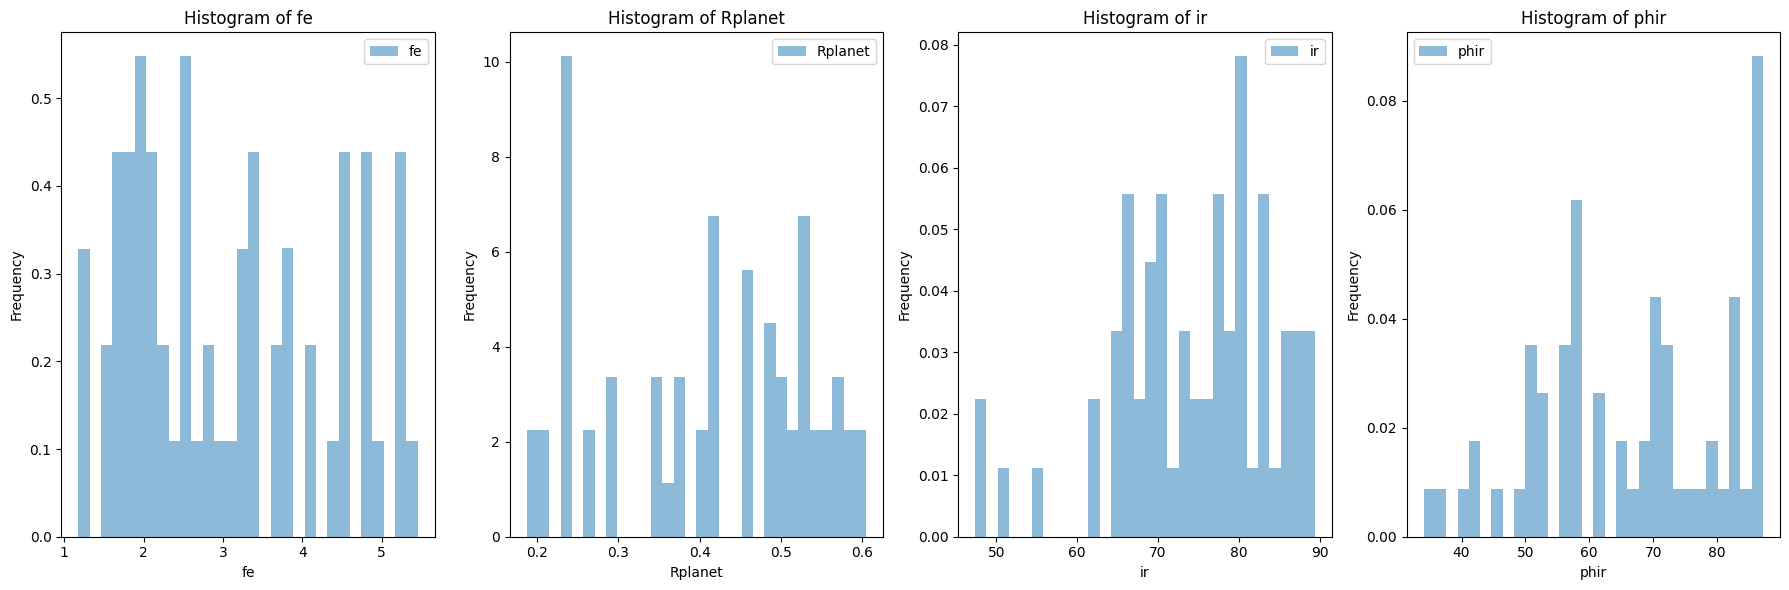

In [36]:
Xs = pd.read_csv(f"{pr.PRDATA_DIR}/ringed_sample-{system_prefix}-{sample_suffix}.csv")
pr.plotSample(Xs,S,props,prefix=f"{system_prefix}-{sample_suffix}",csargs=dict(alpha=0),chargs=dict(bins=20))

System configuration:

rho_obs: 1919.6875067593787, p(rho_obs_fun): 9.074851967431255e-06
delta: 0.004710537036370074, p(delta_fun): 683.651227293996
Acceptance ratio: 0.0014400619063758017


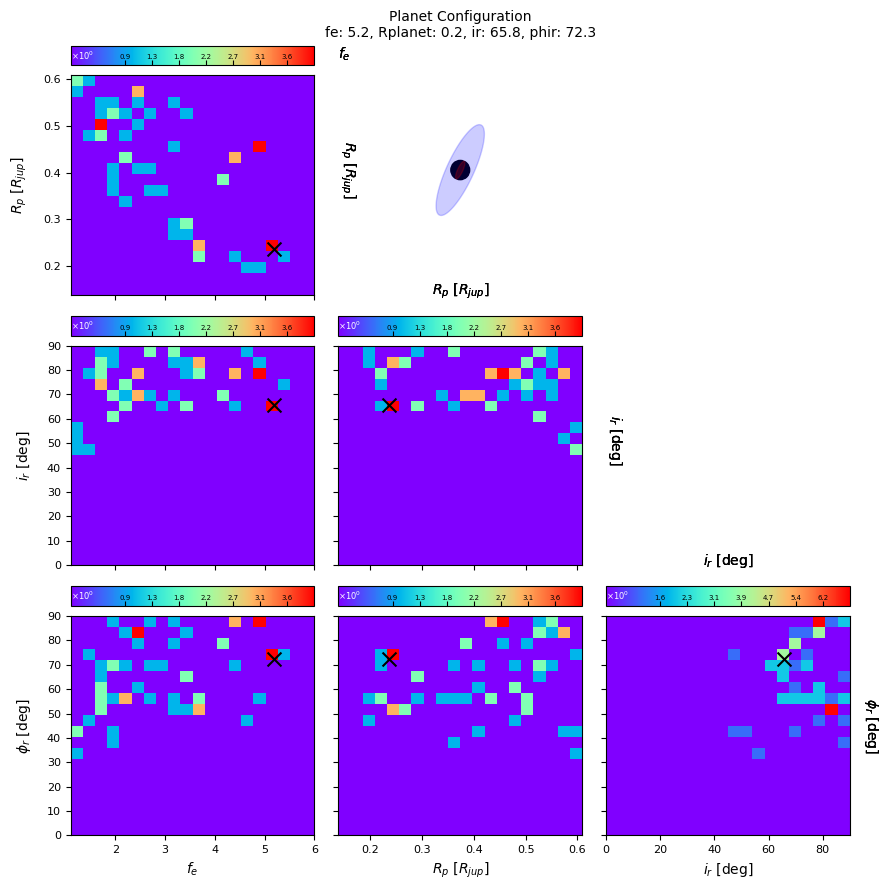

In [37]:
peak_point = pr.get_maximum_kde(Xs, props)
for prop, value in peak_point.items():
    setattr(S, prop, value * props[prop]['scale'])
pr.plotPlanet(Xs,S,props)